# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [1]:
import ROOT
from ROOT import TMVA

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.14/04


## Declare Factory and Input Data

In [2]:
oldfile = ROOT.TFile("data.root")
oldtree = oldfile.Get("Nominal")
nentries = oldtree.GetEntries()

newfile = ROOT.TFile("small.root","recreate")
backgroundTreeB1 = oldtree.CloneTree(0)

for i in range(nentries):
    sample = oldtree.GetBranch('sample').GetEntry(i)
    if (sample == 6):
        backgroundTreeB1.Fill()
    
backgroundTreeB1.AutoSave()

13758

In [3]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

# Input data
# We define now the input data file and we retrieve the ROOT TTree objects with the signal and background input events
inputFileS1 = ROOT.TFile.Open("Xtohh1000.root")
inputFileS2 = ROOT.TFile.Open("Xtohh2000.root")
inputFileB2 = ROOT.TFile.Open("stop.root")
inputFileB3 = ROOT.TFile.Open("ttbar.root")
inputFileB4 = ROOT.TFile.Open("W+jets.root")
inputFileB5 = ROOT.TFile.Open("Zee_221.root")
inputFileB6 = ROOT.TFile.Open("Ztautau_221.root")
inputFileB7 = ROOT.TFile.Open("ZZ_Pw.root")

# retrieve input trees
signalTree1     = inputFileS1.Get("Nominal")
signalTree2     = inputFileS2.Get("Nominal")
backgroundTreeB2 = inputFileB2.Get("Nominal")
backgroundTreeB3 = inputFileB3.Get("Nominal")
backgroundTreeB4 = inputFileB4.Get("Nominal")
backgroundTreeB5 = inputFileB5.Get("Nominal")
backgroundTreeB6 = inputFileB6.Get("Nominal")
backgroundTreeB7 = inputFileB7.Get("Nominal")

signalTree1.Print()

******************************************************************************
*Tree    :Nominal   : Nominal                                                *
*Entries :    23148 : Total =         2341482 bytes  File  Size =     894529 *
*        :          : Tree compression factor =   2.61                       *
******************************************************************************
*Br    0 :sample    : string                                                 *
*Entries :    23148 : Total  Size=     325841 bytes  File Size  =      36319 *
*Baskets :       14 : Basket Size=      32000 bytes  Compression=   8.96     *
*............................................................................*
*Br    1 :EventWeight : EventWeight/F                                        *
*Entries :    23148 : Total  Size=      93425 bytes  File Size  =      18889 *
*Baskets :        4 : Basket Size=      32000 bytes  Compression=   4.92     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree1,     signalWeight     )
loader.AddSignalTree    ( signalTree2,     signalWeight     )
loader.AddBackgroundTree( backgroundTreeB1, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB2, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB3, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB4, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB5, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB6, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB7, backgroundWeight )

## Define input variables 
for branch in signalTree1.GetListOfBranches():
    loader.AddVariable(branch.GetName())

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 23148 events
                         : Add Tree Nominal of type Signal with 56188 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 101752 events
                         : Add Tree Nominal of type Background with 1096 events
                         : Add Tree Nominal of type Background with 5480 events
                         : Add Tree Nominal of type Background with 22618 events
                         : Add Tree Nominal of type Background with 14740 events
                         : Add Tree Nominal of type Background with 84726 events
                         : Add Tree Nominal of type Background with 634 events


## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [5]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70000:nTrain_Background=70000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [7]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='sigmoid', input_dim=19))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1280      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 13,890
Trainable params: 13,890
Non-trainable params: 0
_________________________________________________________________


In [8]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=10:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x840cb70>

Factory                  : Booking method: Keras_Dense
                         : 
Keras_Dense              : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'sample' <---> Output : variable 'sample'
                         : Input : variable 'EventWeight' <---> Output : variable 'EventWeight'
                         : Input : variable 'EventNumber' <---> Output : variable 'EventNumber'
                         : Input : variable 'm_region' <---> Output : variable 'm_region'
                         : Input : variable 'm_FJNbtagJets' <---> Output : variable 'm_FJNbtagJets'
                         : Input : variable 'm_FJpt' <---> Output : variable 'm_FJpt'
                         : Input : variable 'm_FJeta' <---> Output : variable 'm_FJeta'
                         : Input : variable 'm_FJphi' <---> Output : variable 'm_FJphi'

## Train Methods

In [9]:
factory.TrainAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 140000 samples, validate on 170382 samples
Epoch 1/10
140000/140000 [==============================] - 44s 314us/step - loss: 0.0054 - categorical_accuracy: 0.9981 - val_loss: 0.0021 - val_categorical_accuracy: 0.9994

Epoch 00001: val_loss improved from inf to 0.00206, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/10
140000/140000 [==============================] - 45s 325us/step - loss: 6.0350e-04 - categorical_accuracy: 0.9999 - val_loss: 7.6663e-04 - val_categorical_accuracy: 0.9999

Epoch 00002: val_loss improved from 0.00206 to 0.00077, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/10
140000/140000 [==============================] - 47s 334us/step - loss: 8.3826e-04 - categorical_accuracy: 0.9998 - val_loss: 4.7999e-04 - val_categorical_accuracy: 0.9999

Epoch 00003: val_loss improved from 0.00077 to 0.00048, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 4/10
140000/140000 [==============================] - 

## Test  all methods

Here we test all methods using the test data set

In [10]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: Keras_Dense for Classification performance
                         : 
                         : Load model from file: dataset/weights/TrainedModel_Keras_Dense.h5


## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [11]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: Keras_Dense
                         : 
TFHandler_Keras_Dense    :      Variable             Mean             RMS     [        Min             Max ]
                         : ------------------------------------------------------------------------------------
                         :        sample:        0.67668         1.3799   [       -0.64760         5.7307 ]
                         :   EventWeight:       -0.41134         1.2129   [        -5.7307         5.7307 ]
                         :   EventNumber:        -1.8874         3.3027   [        -5.7307         5.7307 ]
                         :      m_region:         1.5509         2.1246   [       -0.71572         5.7307 ]
                         : m_FJNbtagJets:       -0.39016         1.1011   [       -0.67441         5.7307 ]
                         :        m_FJpt:        -1.5202         1.6042   [        -3.2607         5.73

## Plot ROC Curve
We enable JavaScript visualisation for the plots

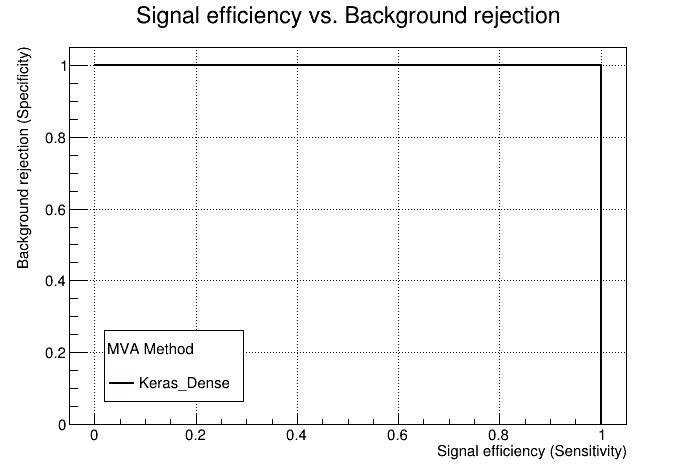

In [12]:
c1 = factory.GetROCCurve(loader)
c1.Draw()